In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
#pd.options.display.max_colwidth = 200
%matplotlib inline

In [3]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
nltk.download('gutenberg')
nltk.download('punkt')
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


### Building the corpus vocabulary

In [5]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


### Building a skip-gram [(target, context), relevancy] generator

this fucntion transforms a sequence of word indexes(list of integers) into tuple of words of the form:
- `(word,word in the same window),with label 1` (Positive samples)
- `(word,random word from the vocabulary), with label 0` (Negative samples)

In [6]:
from keras.preprocessing.sequence import skipgrams
#genearte skip grams
skip_grams=[skipgrams(wid,vocabulary_size=vocab_size,window_size=10) for wid in wids]

#View the sample slip-grams
pairs,labels=skip_grams[0][0],skip_grams[0][1]

for i in range(10):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
      id2word[pairs[i][0]],pairs[i][0],
      id2word[pairs[i][1]],pairs[i][1],
      labels[i] ))

(james (1154), king (13)) -> 1
(king (13), bible (5766)) -> 1
(james (1154), prevailest (10342)) -> 0
(james (1154), empty (1368)) -> 0
(bible (5766), leopards (7872)) -> 0
(bible (5766), james (1154)) -> 1
(king (13), therefrom (6034)) -> 0
(bible (5766), king (13)) -> 1
(james (1154), bible (5766)) -> 1
(king (13), potters (6224)) -> 0


### Building the skip-gram model architecture 

- We'll now leverage `keras` on top of `tensorflow` to build our deep learning architecture for the skip-gram model.
- For this, input will be target word and context or random word pair.
- Each of these are passed to an embedding layer(initialized with random weights) of it's own.
- Once we obtain the word embedding for the target and the context word, we pass it to a merge layer where we compute the dot product of these two vectors.
- Then we pass on this dot product value to a dense sigmoid layer which predicts either a 1 or a 0 depending on if the pair of words contexually relevant or just random words(Y).
- Compute the loss by leveraging the mean_squared_error loss and perform backpropogation with each epoch to update the embedding layer in the process.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1242500     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 1)       0           embedding[0][0]            

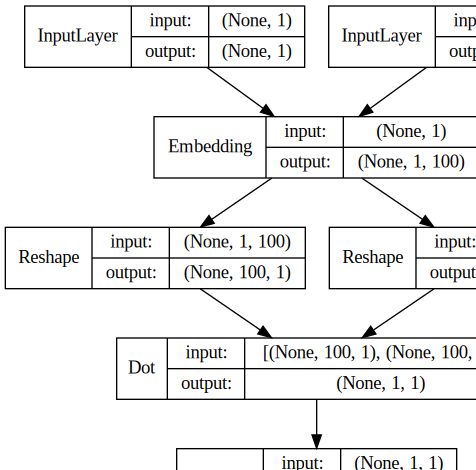

In [7]:
from keras.layers import Input
from keras.models import Model,Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape
from keras.layers import dot

input_target = Input((1,))
input_context = Input((1,))

#syntax: Embedding(input_dim, output_dim, input_length=50)
embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding')
word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)
context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))





### Train the Model

In [8]:
for epoch in range(1,6):
  loss=0
  for i,elem in enumerate(skip_grams):
    pair_first_elem=np.array(list(zip(*elem[0]))[0],dtype='int32')
    pair_second_elem=np.array(list(zip(*elem[0]))[1],dtype='int32')
    labels=np.array(elem[1],dtype='int32')
    X=[pair_first_elem,pair_second_elem]
    Y=labels
    if i % 10000 == 0 :
      print('Processed {} (skip_first,skip_second_relevance) pairs'.format(i))
    loss += model.train_on_batch(X,Y)

  print('Epoch: ', epoch, 'Loss: ', loss)

Processed 0 (skip_first,skip_second_relevance) pairs


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 10000 (skip_first,skip_second_relevance) pairs
Processed 20000 (skip_first,skip_second_relevance) pairs
Epoch:  1 Loss:  6275.409046685323
Processed 0 (skip_first,skip_second_relevance) pairs
Processed 10000 (skip_first,skip_second_relevance) pairs
Processed 20000 (skip_first,skip_second_relevance) pairs
Epoch:  2 Loss:  6096.904687899165
Processed 0 (skip_first,skip_second_relevance) pairs
Processed 10000 (skip_first,skip_second_relevance) pairs
Processed 20000 (skip_first,skip_second_relevance) pairs
Epoch:  3 Loss:  6104.802969401702
Processed 0 (skip_first,skip_second_relevance) pairs
Processed 10000 (skip_first,skip_second_relevance) pairs
Processed 20000 (skip_first,skip_second_relevance) pairs
Epoch:  4 Loss:  6135.303784797434
Processed 0 (skip_first,skip_second_relevance) pairs
Processed 10000 (skip_first,skip_second_relevance) pairs
Processed 20000 (skip_first,skip_second_relevance) pairs
Epoch:  5 Loss:  6183.430989626329


### Get word Embeddings
 
We are only interested in the target word embedding layer. hence we will extract the embeddings from our `word_embedding` layer.
We don't take the embedding at position 0 since none of our words in the vocabulary have a numeric identifier of 0 and we ignore it

In [9]:
#Loading weights from intermediate layer
word_embed_layer=model = Model(input=input_target, output=word_embedding)
weights=word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights,index=id2word.values()).head()

(12424, 100)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
shall,3.765146,-3.840797,4.082027,-3.683385,3.942387,-3.381728,3.631359,-4.146332,3.566450,-3.647259,4.158974,-3.575334,3.635668,-3.940664,-3.895150,-3.513830,-3.638983,3.691860,-3.346908,3.315245,3.517456,4.104646,3.876903,-3.789455,3.689016,-3.832286,-3.496280,3.722668,3.770320,3.812604,3.713732,3.775214,3.706813,-3.731046,3.635707,3.766300,-4.233134,3.969237,3.437849,3.600936,...,3.515239,3.658882,3.759088,3.923856,3.673132,4.069459,-3.731098,-3.633877,-3.987985,-4.143719,-3.310052,3.534633,3.788542,-3.813046,3.921991,4.343029,3.887300,3.817809,3.466528,-3.801922,3.750959,-3.433894,-3.761293,4.026406,-4.145351,-3.670109,3.648438,3.809249,3.394862,-3.802921,-3.462936,-4.150621,-3.987857,-4.005404,-3.803921,3.649960,3.956740,3.386230,-3.171034,-3.476807
unto,3.924401,-3.787629,4.036339,-3.530662,3.945361,-3.593482,3.956114,-3.788278,3.604292,-3.719318,3.665044,-4.441348,3.661065,-4.529509,-3.977043,-4.097148,-3.422819,3.617479,-3.867306,3.462553,3.792755,4.290162,3.744856,-4.189150,3.615911,-4.130394,-3.808927,3.624993,3.856656,3.854232,3.772805,3.756631,3.675516,-4.151784,3.812439,3.880862,-3.987464,4.210212,3.566993,4.029743,...,3.495849,3.782196,3.573123,3.882855,3.808554,3.592845,-4.118523,-3.678966,-4.008389,-3.877395,-3.749179,3.898807,4.014431,-3.834017,3.821036,3.832494,3.830512,4.007080,3.909909,-4.069144,3.580567,-3.907973,-3.642921,3.869929,-3.945102,-3.689554,3.772788,3.693701,3.710051,-3.753011,-3.778807,-3.987612,-3.713165,-4.002015,-3.955718,3.835842,4.007557,3.255337,-3.717043,-3.803515
lord,4.007822,-3.892619,4.329846,-3.997284,3.966766,-3.648906,3.699606,-4.444442,3.843560,-3.991385,4.270219,-4.382982,3.837700,-4.310800,-3.989669,-4.050973,-3.808607,3.909970,-3.856070,3.567204,3.837146,4.282574,3.954871,-4.259682,3.799617,-4.107076,-3.903825,3.862010,4.102306,3.697394,3.963897,3.854313,3.938090,-4.054937,4.122547,3.988072,-4.382445,4.136238,3.593006,4.310384,...,3.535832,3.888634,3.807526,3.677843,4.034471,4.239861,-4.091927,-3.795390,-4.080665,-4.280596,-3.852930,3.951563,3.837181,-3.799644,3.877971,4.396006,3.854706,3.973050,3.793972,-4.241865,3.743700,-3.767538,-3.728976,4.078950,-4.187819,-4.022520,3.641835,3.855478,3.871582,-3.850865,-3.935981,-4.162324,-4.104003,-4.311399,-3.758928,3.794061,4.130698,3.621950,-3.682884,-3.858984
thou,3.432326,-3.780495,3.361479,-3.426305,3.917579,-3.733377,3.586199,-3.821348,3.874038,-3.913490,3.715592,-3.847541,4.005352,-4.045516,-3.731924,-3.665417,-3.694054,3.785661,-3.270719,3.579845,3.432899,4.103485,3.748632,-3.906815,3.751167,-3.689982,-3.483004,3.561963,3.860560,3.559015,3.759570,3.502744,3.500577,-3.824213,3.653557,3.535126,-3.886224,3.924064,3.243997,3.651511,...,3.765272,3.320963,3.479903,3.610601,3.553842,3.702030,-3.797024,-3.297297,-3.967943,-3.793002,-3.494390,3.648956,3.725473,-3.855783,3.591888,3.609402,3.348004,3.536489,3.545504,-3.808792,3.483010,-3.900649,-3.593022,3.595441,-3.767811,-3.465406,3.602426,3.606176,3.397594,-3.609040,-3.842178,-3.676559,-3.820716,-3.676331,-3.493245,3.450671,3.472046,3.600744,-3.393758,-3.607061
thy,3.490105,-3.681381,3.573950,-3.444477,3.649335,-3.641165,3.747992,-3.840070,3.606409,-3.838326,3.802062,-3.697687,3.685002,-3.741254,-3.702634,-3.668328,-3.613906,3.608292,-3.529080,3.497280,3.452306,3.798953,3.771139,-3.775124,3.769373,-3.713107,-3.485518,3.572962,3.872474,3.672132,3.570662,3.668875,3.508713,-3.761473,3.570960,3.677923,-3.887362,3.685111,3.503067,3.791898,...,3.661739,3.355213,3.440194,3.517034,3.751605,4.039054,-3.708902,-3.517524,-3.817241,-3.758221,-3.595846,3.631290,3.629977,-3.855820,3.419296,3.744776,3.453067,3.579063,3.478228,-3.785775,3.456184,-3.740108,-3.662044,3.787098,-3.710589,-3.953504,3.565300,3.667847,3.526678,-3.543760,-3.804039,-3.454995,-3.879539,-3.813155,-3

Here, we can see that each word has a dense embedding of size `(1 x 100)`.Let's apply now the euclidean distance metric on these dense embedding vectors to generate a pairwise distance metric for each word in vocabulary.We can then find out the k-nearest neighbors of each word of interest based on the shortest (euclidean) distance.

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words={search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
               for search_term in ['god','jesus','noah','egypt','john','gospel','moses','famine']}

similar_words

(12424, 12424)


{'egypt': ['fear', 'mouth', 'none', 'right', 'fathers'],
 'famine': ['mountain', 'shame', 'generation', 'cloud', 'shouldest'],
 'god': ['thee', 'said', 'unto', 'come', 'lord'],
 'gospel': ['iron', 'prey', 'everlasting', 'swear', 'appeared'],
 'jesus': ['thus', 'take', 'pass', 'give', 'know'],
 'john': ['worship', 'better', 'fight', 'wind', 'loved'],
 'moses': ['time', 'words', 'hear', 'judah', 'art'],
 'noah': ['wiping', 'witnessed', 'hallow', 'returning', 'shicron']}

Let's visualize these words embeddings now using t-SNE (Which stands for `t-distributed stochastic neighbor embedding` which is dimensionality reduction technique to visualize higher dimension spaces in lower dimensions.

Total words:  48 	word Embedding shapes: (48, 100)


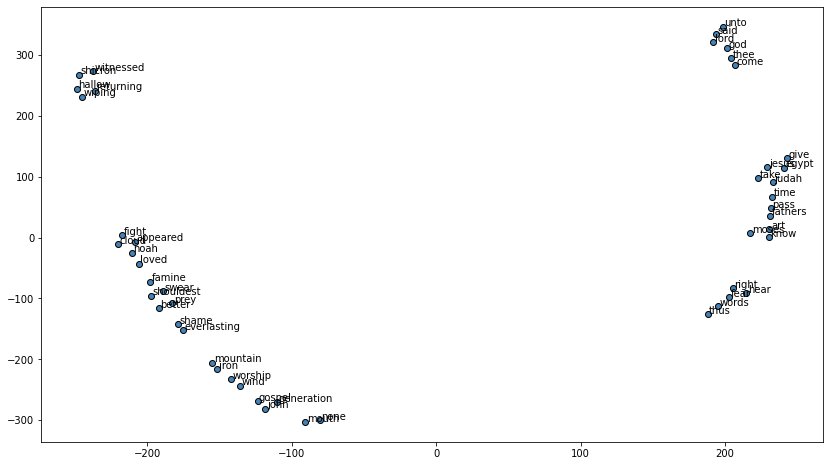

In [14]:
from sklearn.manifold import TSNE

words=sum([[k]+v for k,v in similar_words.items()],[])
words_ids=[word2id[w] for w in words]
word_vectors=np.array([weights[idx] for idx in words_ids])
print('Total words: ',len(words),'\tword Embedding shapes:',word_vectors.shape)

tsne=TSNE(n_components=2,random_state=0,n_iter=10000,perplexity=3)
np.set_printoptions(suppress=True)
T=tsne.fit_transform(word_vectors)
labels=words

plt.figure(figsize=(14,8))
plt.scatter(T[:,0],T[:,1],c='steelblue',edgecolors='k')
for label, x, y in zip(labels,T[:,0],T[:,1]):
  plt.annotate(label,xy=(x+1,y+1),xytext=(0,0),textcoords='offset points')